In this notebook we are going to generate the physiological regressors for one subject from the human connectome and compute their statistical maps.

In [1]:
import numpy as np
from nilearn.image import load_img
import sys
sys.path.append("../code")

In [2]:
hcp_log_data = np.loadtxt("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Physio_log.txt")
bold_img = load_img("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR.nii.gz")
motion = np.loadtxt("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/Movement_Regressors.txt")
n_samples = bold_img.shape[-1]
repetition_time = 0.72
frame_times = np.arange(n_samples)*repetition_time

In [3]:
# So the second column to the respiratary signal, and the third one corresponds to ECG
resp_signal = hcp_log_data[:,1]
ecg_signal = hcp_log_data[:,2]

In [4]:
from regressors import RetroicorPhysio, RVPhysio

In [16]:
retro_ecg = RetroicorPhysio(physio_rate=400, t_r=repetition_time, delta=200, high_pass=0.5, low_pass=3.0, order=2)
ecg_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

In [31]:
from nilearn.glm.first_level import FirstLevelModel

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, ecg_regressors)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["physio1", "physio2", "physio3", "physio4"])
dm.head()

,constant,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,motion_7,motion_8,motion_9,motion_10,motion_11,motion_12,physio1,physio2,physio3,physio4
0,1.0,0.000000,0.110733,0.108724,0.010657,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000
1,1.0,-0.038440,0.117214,0.078874,0.004813,0.0,0.000000,-0.038440,0.006481,-0.029850,-0.005844,0.0,0.000000,0.778288,0.627907,0.977386,-0.211465
2,1.0,0.032012,0.133356,0.101555,0.003953,0.0,0.000000,0.070452,0.016142,0.022681,-0.000860,0.0,0.000000,0.308086,0.951358,0.586201,0.810166
3,1.0,0.040458,0.143815,0.102566,0.000000,0.0,0.000000,0.008446,0.010459,0.001011,-0.003953,0.0,0.000000,-0.326648,0.945146,-0.617459,0.786603
4,1.0,-0.045640,0.122017,0.054368,0.000000,0.0,0.109435,-0.086098,-0.021798,-0.048198,0.000000,0.0,0.109435,-0.436651,0.899631,-0.785650,0.618671


In [32]:
first_level.fit(bold_img, design_matrices=dm)
res_dict = first_level.compute_contrast("physio1+physio2+physio3+physio4", stat_type="F", output_type="all")

FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False)

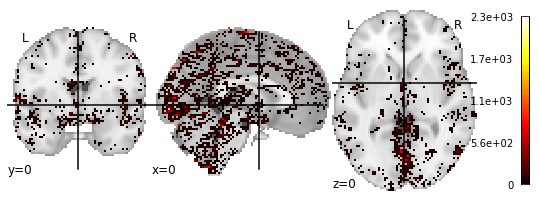

In [123]:
from nilearn import plotting
from nilearn.image import math_img
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict['stat'], 
                                img2=res_dict['p_value']), 
                       cut_coords=(0,0,0))

Compare this with using the signal in white matter and csf...

In [ ]:
"../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/

running  mri_binarize --i ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz --o wm_csf_mask.nii.gz --wm+vcsf

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/javi/Documentos/brainhack-physio-project/notebooks
cmdline mri_binarize.bin --i ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz --o wm_csf_mask.nii.gz --wm+vcsf 
sysname  Linux
hostname javi-Thelio-Major
machine  x86_64
user     javi

input      ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     wm_csf_mask.nii.gz
Binarizing based on matching values
nMatch 18
 0     2
 1    41
 2    77
 3   251
 4   252
 5   253
 6   254
 7   255
 8     7
 9    46
10     4
11     5
12    14
13    43
14    44
15    72
16    31
17    63
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1823063 values in range
Counting number of voxels in first frame
Found 1823063 voxels in final mask
Count: 1823063 625310.599438 21023600 8.671507
mri_binarize done


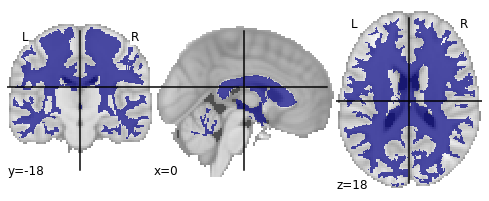

In [75]:
in_file  = "../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz"
cmd = f"mri_binarize --i {in_file} --o wm_csf_mask.nii.gz --wm+vcsf"
print("running ", cmd)
os.system(cmd)
plotting.plot_roi("wm_csf_mask.nii.gz")

In [94]:
# extract signal for this...
from nilearn.image import resample_to_img, mean_img
from nilearn.masking import apply_mask

wmcsf_mask_bold = resample_to_img("wm_csf_mask.nii.gz", mean_img(bold_img), interpolation="nearest")
wm_csf_signal = apply_mask(bold_img, wmcsf_mask_bold)

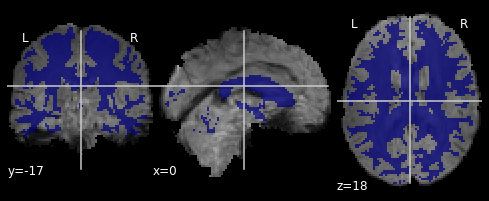

In [99]:
plotting.plot_roi(wmcsf_mask_bold, bg_img=mean_img(bold_img))

In [115]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
acompcor_regs = pca.fit_transform(wm_csf_signal)
print(f"these explained about {np.cumsum(pca.explained_variance_ratio_).max()*100:.2f}% variability")

these explained about 40.86% variability


In [112]:
print(f"these explained about {np.cumsum(pca.explained_variance_ratio_).max()*100:.3f} variability")

these explained about 40.861 variability


In [116]:
dm_acompcor = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, acompcor_regs)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"])
dm_acompcor.head()

,constant,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,motion_7,motion_8,motion_9,motion_10,motion_11,motion_12,pc1,pc2,pc3,pc4,pc5,pc6
0,1.0,0.000000,0.110733,0.108724,0.010657,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,114299.632812,-47428.750000,28627.988281,-18472.970703,-2937.613770,2295.842773
1,1.0,-0.038440,0.117214,0.078874,0.004813,0.0,0.000000,-0.038440,0.006481,-0.029850,-0.005844,0.0,0.000000,111645.273438,-45534.003906,28399.701172,-19357.472656,-3367.405029,1598.984131
2,1.0,0.032012,0.133356,0.101555,0.003953,0.0,0.000000,0.070452,0.016142,0.022681,-0.000860,0.0,0.000000,114886.156250,-44937.199219,28785.062500,-15527.831055,-2715.158936,-4892.270508
3,1.0,0.040458,0.143815,0.102566,0.000000,0.0,0.000000,0.008446,0.010459,0.001011,-0.003953,0.0,0.000000,112403.421875,-43808.429688,28835.406250,-13391.993164,-3003.552734,-7087.681152
4,1.0,-0.045640,0.122017,0.054368,0.000000,0.0,0.109435,-0.086098,-0.021798,-0.048198,0.000000,0.0,0.109435,112116.914062,-46739.171875,30155.742188,-18657.296875,-3494.102051,-8918.366211


In [117]:
first_level.fit(bold_img, design_matrices=dm_acompcor)
res_dict_acompcor = first_level.compute_contrast("pc1+pc2+pc3+pc4+pc5+pc6", stat_type="F", output_type="all")

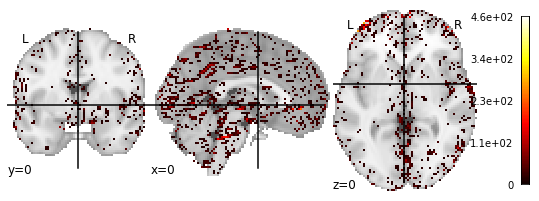

In [124]:
from nilearn import plotting
from nilearn.image import math_img
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), cut_coords=(0,0,0))

In [137]:
apply_mask(res_dict['stat'], math_img("img1==1", img1=wmcsf_mask_bold)).shape

(78126,)